In [317]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
# Causal impact imports
from IPython.core.pylabtools import figsize
figsize(14, 6)
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

In [3]:
import pandas_profiling

In [4]:
retail_df = pd.read_excel("Online_Retail.xlsx")

In [12]:
retail_df.profile_report(minimal=True)

In [5]:
retail_df.shape

(541909, 8)

# Data cleaning

In [6]:
#remove rows where customerID are NA
retail_df.dropna(subset=['CustomerID'],how='all',inplace=True)

In [7]:
retail_df_filtered = retail_df[retail_df['Quantity'] > 0]

restrict the data to 1 full year because its better to use a metric in per month or year in RFM analysis

In [8]:
retail_df_filtered = retail_df_filtered[retail_df_filtered['InvoiceDate'] >= "2010-12-09"]

In [9]:
print("Number of unique transactions:",  retail_df_filtered['InvoiceNo'].nunique())
print("Number of unique products:", retail_df_filtered['StockCode'].nunique())
print("Number of unique customers", retail_df_filtered['CustomerID'].nunique())
print("Customer with most transactions:", retail_df_filtered['CustomerID'].value_counts().index[0])
print(round(retail_df_filtered['Quantity'].isnull().sum() * 100 / len(retail_df_filtered),2))


Number of unique transactions: 17858
Number of unique products: 3630
Number of unique customers 4275
Customer with most transactions: 17841.0
0.0


# RFM analysis

RFM (**Recency, Frequency, Monetary**) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future and personalization services.

Recency (R): Days since last purchase 

Frequency (F): Total number of purchases 

Monetary Value (M): Total money this customer spent

## Recency
To calculate recency, we need to choose a data point from which we evaluate how many days ago was the customer's last purchase

In [10]:
# Last date in our dataset
retail_df_filtered['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [11]:
# Last data we have is 2011-12-09, use that as reference
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [12]:
# Create new column called date which contains the date of invoice only
retail_df_filtered['date'] = retail_df_filtered['InvoiceDate'].dt.date

In [355]:
retail_df_filtered.head(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09,47.40
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09,37.20
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09,15.30
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,31.80
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,15.90
19637,537879,22694,WICKER STAR,6,2010-12-09 08:34:00,2.10,14243.0,United Kingdom,2010-12-09,12.60
19638,537879,82494L,WOODEN FRAME ANTIQUE WHITE,12,2010-12-09 08:34:00,2.95,14243.0,United Kingdom,2010-12-09,35.40
19639,537879,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-09 08:34:00,2.95,14243.0,United Kingdom,2010-12-09,17.70
19640,537880,21669,BLUE STRIPE CERAMIC DRAWER KNOB,12,2010-12-09 09:14:00,1.25,12963.0,United Kingdom,2010-12-09,15.00
19641,537880,48187,DOORMAT NEW ENGLAND,2,2010-12-09 09:14:00,7.95,12963.0,United Kingdom,2010-12-09,15.90


In [14]:
# Group by customers and check last date of purchase
recency_df = retail_df_filtered.groupby('CustomerID',as_index=False)['date'].max()

In [15]:
recency_df.columns = ['CustomerID', 'LastPurchaseDate']

In [16]:
# Calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


We have calculated when each customer made a purchase. Eg: Customer 12346 made a purchase 325 days ago

In [17]:
recency_df.drop('LastPurchaseDate', axis=1, inplace=True)

## Frequency
Frequency helps us to know how many times a customer purchased from us. TO do that we need to check how many invoices are registered by the same customer.

In [18]:
# drop duplicates
retail_df_filtered_copy = retail_df_filtered.copy()
retail_df_filtered_copy.drop_duplicates(subset=['InvoiceNo','CustomerID'], keep='first', inplace=True)
# calculate frequency of purchases
frequency_df = retail_df_filtered_copy.groupby(['CustomerID'],as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,6
2,12348.0,4
3,12349.0,1
4,12350.0,1


## Monetary
The monetary attribute answers the question of **How much money did the customer spent over time?**

To do that, first we will create a new column total cost to have the total price per invoice.

In [19]:
# Create total cost column
retail_df_filtered['TotalCost'] = retail_df_filtered['Quantity'] * retail_df_filtered['UnitPrice']


In [20]:
monetary_df = retail_df_filtered.groupby(by='CustomerID', as_index=False).agg({'TotalCost':'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,3598.21
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


## Now we create the RFM table

In [21]:
# merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df, on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12347.0,2,6
2,12348.0,75,4
3,12349.0,18,1
4,12350.0,310,1


In [22]:
rfm_df = temp_df.merge(monetary_df, on='CustomerID')
# Use customerID as index
rfm_df.set_index('CustomerID', inplace=True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,6,3598.21
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


## Verifying the correctness of the RFM table

In [23]:
retail_df_filtered[retail_df_filtered['CustomerID'] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [24]:
(now - dt.date(2011,1,18)).days == 325

True

## Customer segments with RFM Model
Before moving to customer segments, Let's see the application of Pareto Principle ~ commonly referred to as the 80-20 rule on our datset by applying it to our RFM variables.

Pareto's rule says that **80% of the results come from 20% of cause.**

Similarly, **20% customers contribute to 80% of the total revenue.** Verify that because that will help us to know which customers to focus on when marketing new products.

### Applying the 80-20 rule

In [25]:
# Get 80% of revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8

In [26]:
print(f"80% of revenue is {round(pareto_cutoff, 2)}")

80% of revenue is 6910209.44


In [27]:
customer_rank = rfm_df
# Create a new column that is the rank of the value of coverage in ascending order
customer_rank['Rank'] = customer_rank['Monetary'].rank(ascending=0)
customer_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,9.0
12347.0,2,6,3598.21,429.0
12348.0,75,4,1797.24,973.0
12349.0,18,1,1757.55,1002.0
12350.0,310,1,334.40,3050.0


**Top Customer**

In [28]:
customer_rank.sort_values(by='Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
14646.0,1,74,280206.02,1.0
18102.0,0,57,233736.93,2.0
17450.0,8,44,192521.95,3.0
16446.0,0,2,168472.50,4.0
14911.0,1,194,140359.03,5.0
...,...,...,...,...
17956.0,249,1,12.75,4271.0
16454.0,44,2,6.90,4272.0
14792.0,63,1,6.20,4273.0


In [29]:
# get the top 20% of customers
top_20_cutoff = 4275 * 0.2
top_20_cutoff

855.0

In [30]:
# Sum the monetary values over the customers with rank <= 855
revenueByTop20 = customer_rank[customer_rank['Rank'] <= 855]['Monetary'].sum()
round(revenueByTop20,2)

6430268.48

In [31]:
revenueByBottom80 = customer_rank[customer_rank['Rank'] >= 855]['Monetary'].sum()
revenueByBottom80

2209537.243

In this case 80% of revenue is achived by the top 20% of TOP customers.

### Applying RFM score formula

The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frenqeucy and Monetary. **Four** is the highest value, and **one** is the lowest. A final RFM score is calculated by simply combining individual RFM score numbers.

Note: Quantiles score from 1-5 offer better granularity, in case the business needs that but it will be more challenging to create segments since we have 555 possible combinations so we will use quartiles.

In [32]:
rfm_df = rfm_df[['Recency','Frequency','Monetary']]

In [33]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,305.580
0.50,50.0,2.0,668.140
0.75,134.0,5.0,1640.825


In [34]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 305.58000000000004, 0.5: 668.14, 0.75: 1640.8250000000003}}

**Creation of RFM segmentation table**

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [35]:
#Arguments (x= value, p= recency, monetary_value, frequency, d = quantiles_dict)
def Rscore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [36]:
rfm_segmentation = rfm_df
rfm_segmentation['R_quartile'] = rfm_segmentation['Recency'].apply(Rscore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [37]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,4
12347.0,2,6,3598.21,4,4,4
12348.0,75,4,1797.24,2,3,4
12349.0,18,1,1757.55,3,1,4
12350.0,310,1,334.40,1,1,2


In [38]:
quantiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,305.580
0.50,50.0,2.0,668.140
0.75,134.0,5.0,1640.825


In [39]:
Rscore(75, 'Recency', quantiles)

2

In [40]:
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)

Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

In [41]:
rfm_segmentation[rfm_segmentation['RFM_Score']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_quartile,F_Quartile,M_Quartile,RFM_Score
CustomerID,,,,,,,
14646.0,1,74,280206.02,4,4,4,444
18102.0,0,57,233736.93,4,4,4,444
17450.0,8,44,192521.95,4,4,4,444
14911.0,1,194,140359.03,4,4,4,444
14156.0,9,54,117057.43,4,4,4,444
17511.0,2,29,87591.70,4,4,4,444
16684.0,4,28,66653.56,4,4,4,444
14096.0,4,17,65164.79,4,4,4,444
13694.0,3,49,64197.50,4,4,4,444


In [42]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFM_Score']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFM_Score']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='111']))

Best Customers:  443
Loyal Customers:  831
Big Spenders:  1069
Almost Lost:  62
Lost Customers:  9
Lost Cheap Customers:  434


Now that we know our customer segments, we can choose how to target and deal with each segment.

EX:

**Best Customers** - Reward them

**At risk** - Send them emails to envouraged them to shop

# K-Means clustering on RFM variables

In [43]:
rfm_data = rfm_df[['Recency','Frequency','Monetary']]

In [44]:
# Feature correlations
rfm_data.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.264966,-0.121614
Frequency,-0.264966,1.000000,0.554750
Monetary,-0.121614,0.554750,1.000000


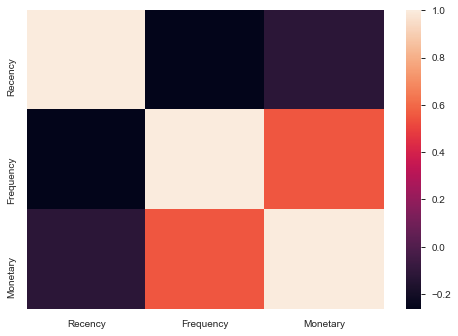

In [45]:
sns.heatmap(rfm_data.corr())

We have negative correlation between:
 - recency and frequency
 - recency and monetary

On the other hand, the correlation between monetary and frequency is positive comapred to negative ones but still not that strong.

**Visualize feature distribution**

To get a better understanding of the dataset, we can construct a scatter matrix of each of the three features in the RFM data.

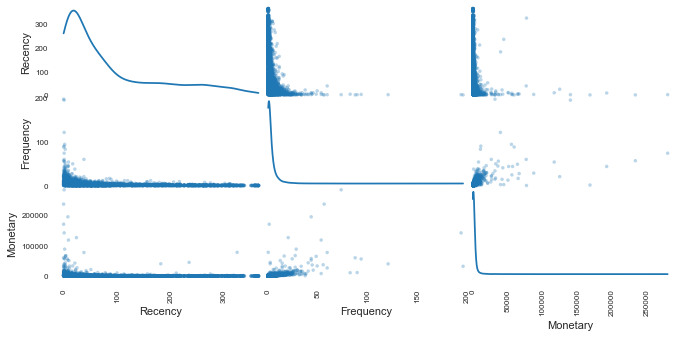

In [46]:
scatter_matrix(rfm_data, alpha= 0.3, figsize=(11,5), diagonal='kde');

We can notice that we have skewed distributions on all the variables and outliers exists.

This indicates how normalization is required to make the data features normally distributed as clustering algorithms require them to be normally distributed.

**Data Normalization**

In [47]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) # cannot take log(0) so add small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [48]:
log_data = pd.DataFrame({'Monetary': rfm_m_log, 'Recency': rfm_r_log, 'Frequency':rfm_f_log})

In [49]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12347.0,8.188220,0.741937,1.791759
12348.0,7.494063,4.318821,1.386294
12349.0,7.471733,2.895912,0.000000
12350.0,5.812637,5.736895,0.000000


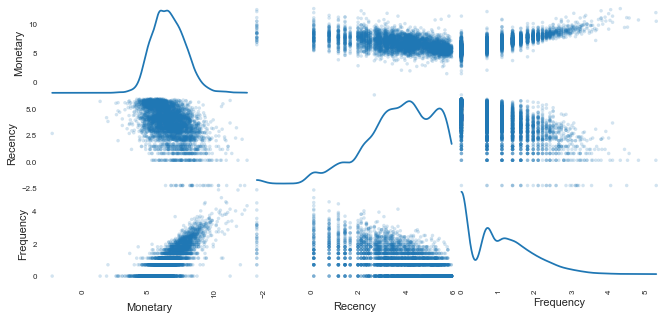

In [50]:
scatter_matrix(log_data, alpha=0.2, figsize=(11,5), diagonal='kde');

Now we have better distribtuons, more normalized, not the case with Recency and Frequency.

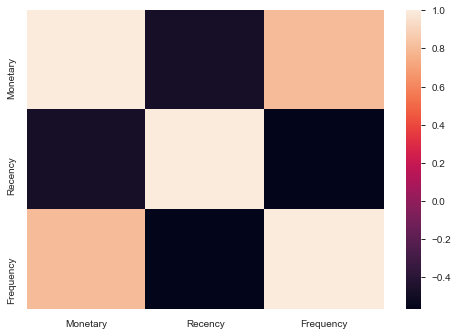

In [51]:
sns.heatmap(log_data.corr());

In [52]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.472082,0.804392
Recency,-0.472082,1.000000,-0.567138
Frequency,0.804392,-0.567138,1.000000


Now frequncy and monetary are strongly correlated

**Implementing K-means**

A common challenge with k-means is that you must tell it how many clusters you expect. Figuring how many clusters we need is not obvious from data, therefore we will try different cluster numbers and check their silhoutte coefficient. The silhoutte coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The elbow method can be used to determine the number of clusters as well.

**Note**: K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called **k-means++**.

In [53]:
matrix = log_data.as_matrix()

In [318]:
matrix.shape

(4275, 3)

In [321]:
distortions = []
N_clusters = range(2,10)
for n_clusters in N_clusters:
    kmeans = KMeans(init='k-means++', n_clusters= n_clusters,
                   n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    distortions.append(sum(np.min(cdist(matrix, kmeans.cluster_centers_, 'euclidean'), axis=1)) / matrix.shape[0])
    silhouette_avg = silhouette_score(matrix, clusters)
    print(f"For n_clusters = {n_clusters}, The average silhoutte_score is: {silhouette_avg}")

For n_clusters = 2, The average silhoutte_score is: 0.419374989195775
For n_clusters = 3, The average silhoutte_score is: 0.32907903927771665
For n_clusters = 4, The average silhoutte_score is: 0.34082719097006087
For n_clusters = 5, The average silhoutte_score is: 0.3175326908148402
For n_clusters = 6, The average silhoutte_score is: 0.32085908411324554
For n_clusters = 7, The average silhoutte_score is: 0.3179346459646815
For n_clusters = 8, The average silhoutte_score is: 0.3061529107114686
For n_clusters = 9, The average silhoutte_score is: 0.3062029347925408


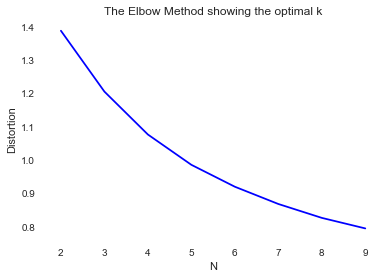

In [322]:
plt.plot(N_clusters, distortions, 'bx-')
plt.xlabel('N')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The **best silhoutte score** obtained is when the number of clusters is 2.

In [357]:
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print("Score of silhoutte: {:<.3f}".format(silhouette_avg))


Score of silhoutte: 0.318


**Visualize Clusters**

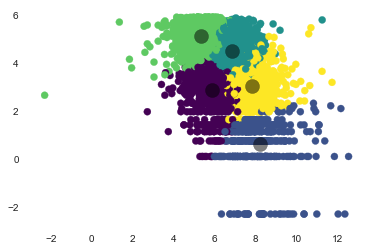

In [359]:
# Scatter plot
plt.scatter(matrix[:, 0], matrix[:,1], c = clusters_customers,
           s = 50, cmap='viridis')
# select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

In [362]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12347.0,8.188220,0.741937,1.791759
12348.0,7.494063,4.318821,1.386294
12349.0,7.471733,2.895912,0.000000
12350.0,5.812637,5.736895,0.000000


In [364]:
log_data['cluster'] = kmeans.labels_

In [366]:
log_data.cluster.value_counts()

3    1171
2    1000
4     894
0     835
1     375
Name: cluster, dtype: int64

In [367]:
clust3 = log_data[log_data['cluster'] == 3]

In [372]:
clus_df = log_data[['cluster']].reset_index()

In [374]:
final_df = retail_df_filtered.merge(clus_df, how='left', on=['CustomerID'])

In [380]:
clust4 = final_df[final_df['cluster'] == 4]

In [385]:
clust1 = final_df[final_df['cluster'] == 1]

In [57]:
# Number of customer in each cluster
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['NumberCustomers']).T

,0,1
NumberCustomers,2615,1660


**Note: We can check the median of each variable (F,M,R) in each cluster in order to understand what customers does each cluster represent.

**Conclusion - Perspective after applying k-means clustering:**

We did obtain a somewhat clearly separated clusters.

Limitations of k-means clustering:
 - There is no assurance that it will lead to the global best solution.
 - Cant deal with different shapes (not circular) and consider one point's probability of belonging to more than one cluster.
 
These disadvantages of k-means means that for many datasets (especially low-dimensional datasets) It may not perform as well as you might hope. Here come Gaussian Mixture Model in help by providing greater flexibility due to clusters having unconstrained covariances and allowing probabilistic cluster assignment.
 
**Note**: A common practice before doing clustering is PCA. PCA calculates the dimensions which best maximize variance. It gives directions on how many components to consider for GMM. Basically, it does dimensioanlity reduction while keeping the most important feature, characteristics (combinations of features best describe customers). But as we are not dealing with high dimension we won't do it for this case.
 
**Implementing a GMM**
 
While k-means is easy to understand and implement. It fails to deal with non-circular shapes and lack of probabilistic cluster assignment - meaning that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

In [58]:
gmm = GaussianMixture(n_components=2).fit(matrix)
labels = gmm.predict(matrix)

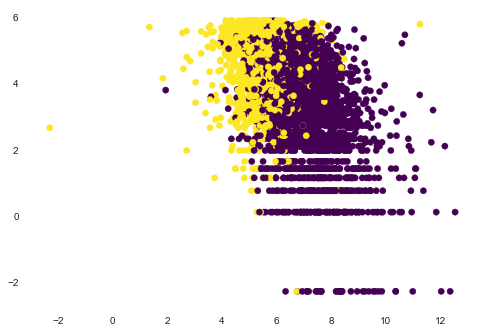

In [59]:
plt.scatter(matrix[:,0], matrix[:,1], c=labels, s=40, cmap='viridis');

GMM is not any better than k-means at this level

**Conclusion - Perspectives**

At this juncture, it makes sense to show interested stakeholders the cluster solutions and get their input. The decision should be based upon how the business plans to use the results, and the **level of granulairty** they want to see in the clusters. What range of customer behavior from high-to-low value customers are the business stakegolders interested in exploring? And from the answer to that question, various methods of clustering can be further exploited whether applied on RFM variables or directly on the transaction dataset available.

Score of silhoutte: 0.318


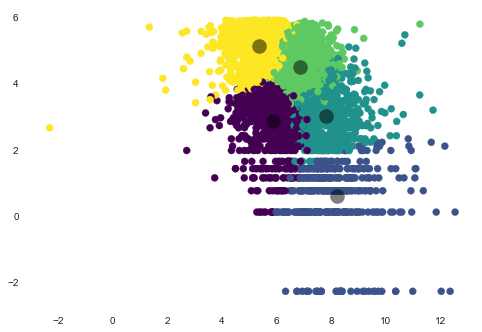

In [60]:
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print("Score of silhoutte: {:<.3f}".format(silhouette_avg))

plt.scatter(matrix[:, 0], matrix[:,1], c = clusters_customers,
           s = 50, cmap='viridis')
# select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5);

# Causal Impact

In [61]:
retail_df_filtered.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09,47.4


In [62]:
ci_df = retail_df_filtered.groupby(['InvoiceNo','date','CustomerID'],as_index=False).agg({'TotalCost':sum})

In [144]:
ci_df.head()

,TotalSpent,InvoiceNo,CustomerID
date,,,
2010-12-09,213.30,537879,14243.0
2010-12-09,365.80,537880,12963.0
2010-12-09,956.50,537881,15513.0
2010-12-09,141.95,537882,15079.0
2010-12-09,63.00,537883,14437.0


In [63]:
ci_df.columns = ['InvoiceNo','date','CustomerID','TotalSpent']

In [64]:
ci_df['date'] = pd.to_datetime(ci_df['date'], infer_datetime_format=True)

In [65]:
ci_df = ci_df.set_index('date')

ci_df.index = pd.to_datetime(ci_df.index)

ci_df = ci_df[['TotalSpent','InvoiceNo','CustomerID']]

In [132]:
ci_df.head()

,TotalSpent,InvoiceNo,CustomerID
date,,,
2010-12-09,213.30,537879,14243.0
2010-12-09,365.80,537880,12963.0
2010-12-09,956.50,537881,15513.0
2010-12-09,141.95,537882,15079.0
2010-12-09,63.00,537883,14437.0


In [ ]:
CausalImpact()

In [113]:
ci_df2 = retail_df_filtered.groupby(['date'],as_index=False).agg({'TotalCost':sum})

In [116]:
ci_df2['date'] = pd.to_datetime(ci_df2['date'], infer_datetime_format=True)

In [120]:
ci_df2 = ci_df2.set_index('date')

In [126]:
pd.to_datetime(np.min(ci_df2.index.values))

Timestamp('2010-12-09 00:00:00')

In [127]:
pre_period = [pd.to_datetime(np.min(ci_df2.index.values)), pd.to_datetime('20111002']
post_period = [pd.to_datetime('20111010'), pd.to_datetime(np.max(ci_df2.index.values))]

In [135]:
ci = CausalImpact(ci_df2, pre_period, post_period, prior_level_sd=None)

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    45483.57           2410629.15
Prediction (s.d.)         34402.89 (5013.79) 1823353.04 (265730.85)
95% CI                    [24911.57, 44565.26][1320313.15, 2361958.93]

Absolute effect (s.d.)    11080.68 (5013.79) 587276.11 (265730.85)
95% CI                    [918.31, 20572.0]  [48670.22, 1090316.0]

Relative effect (s.d.)    32.21% (14.57%)    32.21% (14.57%)
95% CI                    [2.67%, 59.8%]     [2.67%, 59.8%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.5%

For more details run the command: print(impact.summary('report'))


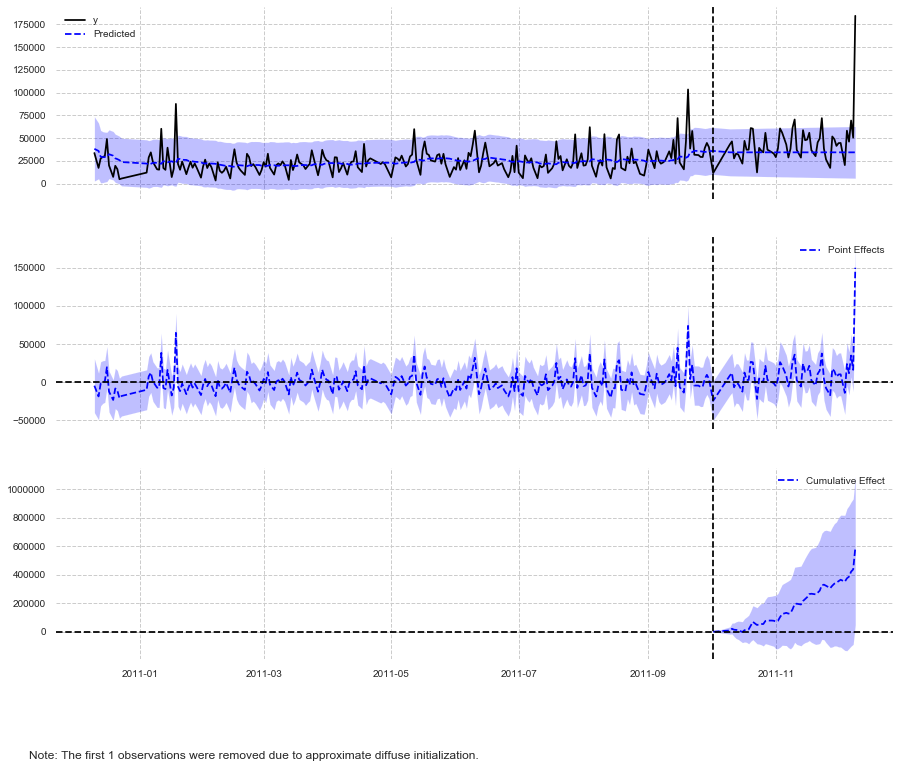

In [136]:
print(ci.summary())
ci.plot()

In [140]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 45483.57. By contrast, in the absence of an
intervention, we would have expected an average response of 34402.89.
The 95% interval of this counterfactual prediction is [24911.57, 44565.26].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 11080.68 with a 95% interval of
[918.31, 20572.0]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2410629.15.
By contrast, had the intervention not taken place, we would have expected
a sum of 1823353.04. The 95% interval of this prediction is [1320313.15, 2361958.93].


The above results are given in terms of absolute numbers. In r

**Outlook**

This model takes only 1 unique date point at each date, therefore how can we design this model to have more granularity?
 - Split data by groups of RFM eg: For each group run a rfm analysis, however there are 61 groups
 - Group by clusters. same cluster, similar behaviour.
 - Add seasonality?
 - Design an actual intervention point?

Data for ETL
 - Data should be split into products and customer base
 - Products - StockCode(int), description(str), price(float)
 - Customers - InvoiceNo(str), InvoiceDate(datetime), QuantityPurchased(int), CustomerID(str), Country(str)

Clustering does not peform very well. Ways to improved?
 - turn to classification

## Cluster intervention

In [429]:
clust1 = clust1[clust1['TotalCost'] != 168469.60]

In [430]:
clust1.TotalCost.max()

7144.719999999999

In [431]:
clust1.head()

test_clust1 = clust1.groupby(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'date', 'cluster'], as_index=False).agg({'TotalCost':sum})

test_clust1_1 = test_clust1.groupby(['date'],as_index=False).agg({'TotalCost':sum})

test_clust1_1['date'] = pd.to_datetime(test_clust1_1['date'], infer_datetime_format=True)

test_clust1_1 = test_clust1_1.set_index('date')

test_clust1_1.head()

pre_period = [pd.to_datetime(np.min(test_clust1_1.index.values)), pd.to_datetime('20111002')]
post_period = [pd.to_datetime('20111010'), pd.to_datetime(np.max(test_clust1_1.index.values))]

ci1 = CausalImpact(test_clust1_1, pre_period, post_period, prior_level_sd=None)

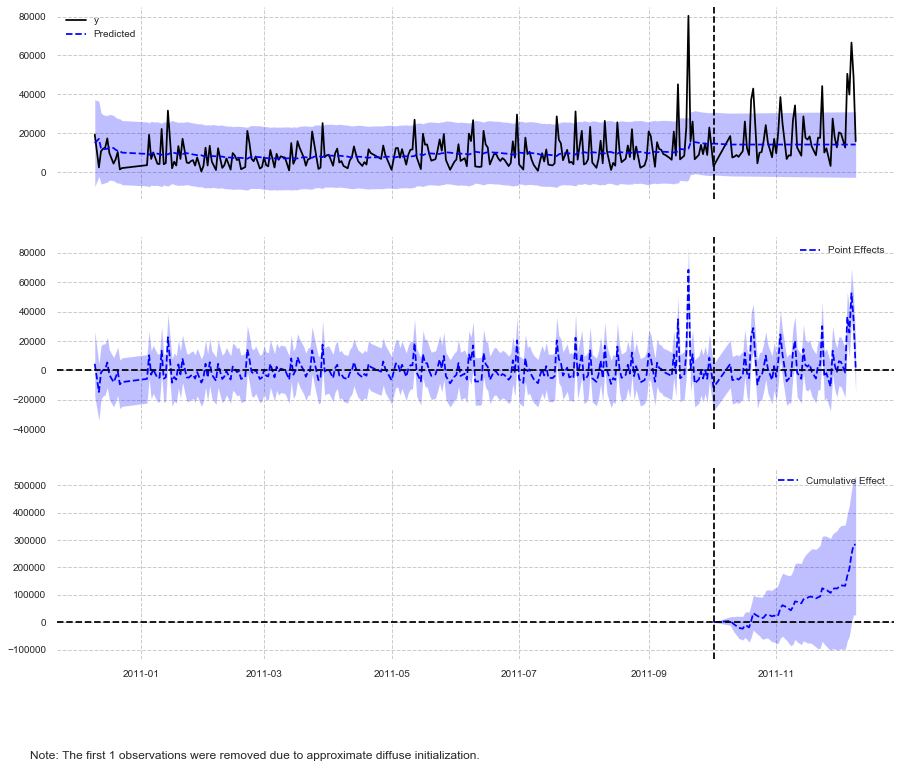

In [432]:
ci1.plot()

In [418]:
final_df.groupby(['cluster'], as_index=False).agg({'TotalCost':'mean'})

,cluster,TotalCost
0,0,10.761473
1,1,29.776529
2,2,19.580535
3,3,13.146284
4,4,21.592749


In [410]:
clust4.head()

test_clust4 = clust4.groupby(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'date', 'cluster'], as_index=False).agg({'TotalCost':sum})

test_clust4_1 = test_clust4.groupby(['date'],as_index=False).agg({'TotalCost':sum})

test_clust4_1['date'] = pd.to_datetime(test_clust4_1['date'], infer_datetime_format=True)

test_clust4_1 = test_clust4_1.set_index('date')

test_clust4_1.head()

pre_period = [pd.to_datetime(np.min(test_clust4_1.index.values)), pd.to_datetime('20111002')]
post_period = [pd.to_datetime('20111010'), pd.to_datetime(np.max(test_clust4_1.index.values))]

ci1 = CausalImpact(test_clust4_1, pre_period, post_period, prior_level_sd=None)

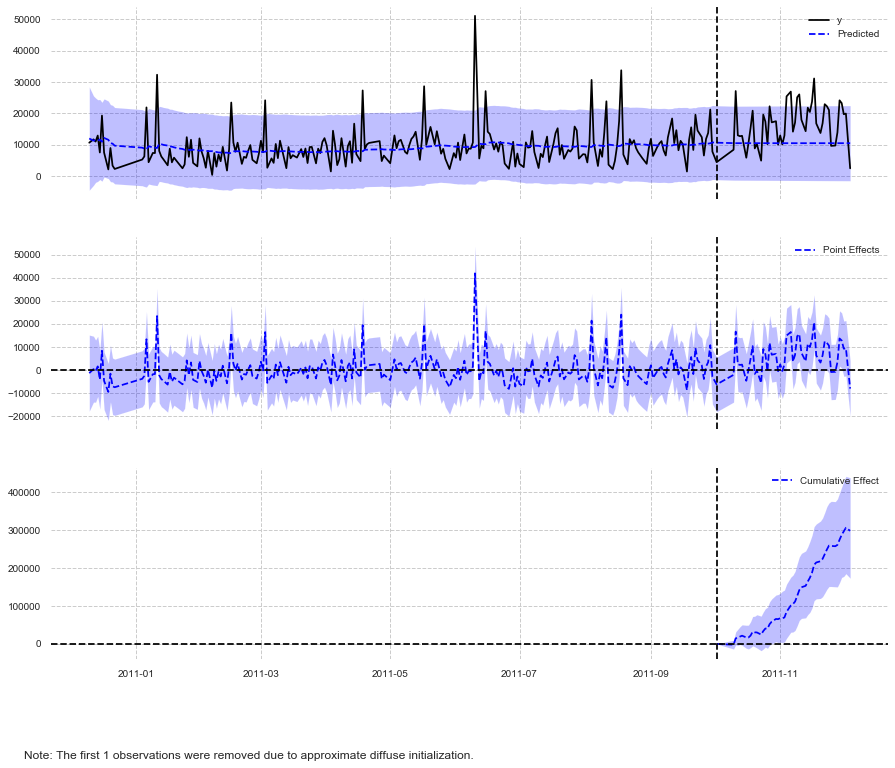

In [411]:
ci1.plot()

In [424]:
clust1.sort_values('TotalCost', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost,cluster
384695,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.60,1
235950,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,2011-09-20,7144.72,1
295341,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,2011-10-27,4992.00,1
158818,558526,23173,REGENCY TEAPOT ROSES,540,2011-06-30 11:01:00,8.15,17949.0,United Kingdom,2011-06-30,4401.00,1
19433,540689,22470,HEART OF WICKER LARGE,1284,2011-01-11 08:43:00,3.21,17450.0,United Kingdom,2011-01-11,4121.64,1
...,...,...,...,...,...,...,...,...,...,...,...
211176,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.00,14646.0,Netherlands,2011-08-26,0.00,1
316251,574920,23480,MINI LIGHTS WOODLAND MUSHROOMS,1,2011-11-07 16:34:00,0.00,13985.0,United Kingdom,2011-11-07,0.00,1
246643,568384,M,Manual,1,2011-09-27 09:46:00,0.00,12748.0,United Kingdom,2011-09-27,0.00,1
211178,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.00,14646.0,Netherlands,2011-08-26,0.00,1


In [422]:
clust4.TotalCost.max()

38970.0

## Test intervention

In [323]:
test = retail_df_filtered.groupby(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'date'],as_index=False).agg({'TotalCost':sum})

In [324]:
test = test.sort_values(by=['InvoiceDate'],ascending=True)

In [325]:
test.iloc[25182:,]['UnitPrice'] = test.iloc[25182:,]['UnitPrice'] * 0.88

In [326]:
test2 = test.iloc[25182:,]

In [338]:
test2.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
380273,581587,22555,PLASTERS IN TIN STRONGMAN,24,2011-12-09 12:50:00,1.452,12680.0,France,2011-12-09,19.8
380272,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,16,2011-12-09 12:50:00,1.716,12680.0,France,2011-12-09,15.6
380284,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,8,2011-12-09 12:50:00,3.652,12680.0,France,2011-12-09,16.6
380277,581587,22631,CIRCUS PARADE LUNCH BOX,24,2011-12-09 12:50:00,1.716,12680.0,France,2011-12-09,23.4
380285,581587,23256,CHILDRENS CUTLERY SPACEBOY,8,2011-12-09 12:50:00,3.652,12680.0,France,2011-12-09,16.6


In [329]:
test3 = test.iloc[0:25182,]

In [331]:
test3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
0,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,15.9
1,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09,47.4
2,537879,22694,WICKER STAR,6,2010-12-09 08:34:00,2.10,14243.0,United Kingdom,2010-12-09,12.6
3,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09,37.2
4,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,31.8


In [332]:
test2['Quantity'] = test2['Quantity'] * 2

In [335]:
test4 = pd.concat([test3, test2])

In [339]:
test4.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
0,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,15.9
1,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09,47.4
2,537879,22694,WICKER STAR,6,2010-12-09 08:34:00,2.10,14243.0,United Kingdom,2010-12-09,12.6
3,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09,37.2
4,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,31.8


In [340]:
test = test4

In [341]:
test['TotalCost'] = test['Quantity'] * test['UnitPrice']

In [342]:
test_df = test.groupby(['InvoiceNo','date','CustomerID',],as_index=False).agg({'TotalCost':sum})

In [343]:
test_df.columns = ['InvoiceNo','date','CustomerID','TotalSpent']

In [344]:
test_df = test_df.set_index('date')

test_df.index = pd.to_datetime(test_df.index)

In [345]:
test_df.shape

(17858, 3)

In [346]:
test_df1 = test_df.groupby(['date'], as_index=True).agg({'TotalSpent':sum})

In [347]:
test_df1.shape

(298, 1)

In [348]:
pre_period1 = [pd.to_datetime(np.min(test_df1.index.values)), pd.to_datetime('20111002')]
post_period1 = [pd.to_datetime('20111010'), pd.to_datetime(np.max(test_df1.index.values))]

ci1 = CausalImpact(test_df1, pre_period1, post_period1, prior_level_sd=None)

ci1.plot()

In [353]:
print(ci1.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79742.75           4226365.93
Prediction (s.d.)         61335.56 (9371.6)  3250784.54 (496694.7)
95% CI                    [42569.37, 79305.36][2256176.48, 4203183.94]

Absolute effect (s.d.)    18407.2 (9371.6)   975581.39 (496694.7)
95% CI                    [437.4, 37173.39]  [23182.0, 1970189.45]

Relative effect (s.d.)    30.01% (15.28%)    30.01% (15.28%)
95% CI                    [0.71%, 60.61%]    [0.71%, 60.61%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 97.7%

For more details run the command: print(impact.summary('report'))


In [354]:
print(ci1.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 79742.75. By contrast, in the absence of an
intervention, we would have expected an average response of 61335.56.
The 95% interval of this counterfactual prediction is [42569.37, 79305.36].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 18407.2 with a 95% interval of
[437.4, 37173.39]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 4226365.93.
By contrast, had the intervention not taken place, we would have expected
a sum of 3250784.54. The 95% interval of this prediction is [2256176.48, 4203183.94].


The above results are given in terms of absolute numbers. In re